This post is intended to explain:

* What the `shape` attribute of a pymc3 RV is.
* What's the difference between an RV's and its associated distribution's `shape`.
* How does a distribution's `shape` determine the `shape` of its `logp` output.
* The potential trouble this can bring with samples drawn from the prior or from the posterior predictive distributions.
* The many implicit semantically relevant shapes associated with pymc3 models. We will follow the naming convention used by tensorflow probability and talk about sample, batch and event shapes.
* I plan to write a separate post with some best practices to avoid falling into the many circles of shape hell (or at least be able to maneuver inside them).

## The origin of all ~~evil~~ ambiguity

Before going into the depths of PyMC3, we'll take a detour around `numpy`'s random number generators to introduce the many semantically relevant shapes involved with random variables, samples drawn from probability distributions and how these affect the computed probability densities.

`numpy` has no concept of a random variable class, it provides some random number generators from which you can draw some samples that follow a particular probability distribution (I'm purposely not mentioning `scipy.stats` here). Lets draw some numbers using `numpy.random.normal`:

In [1]:
import numpy as np

np.random.seed(12345)

In [2]:
# Lets make a call using all the defaults
x = np.random.normal()
print("Sample's value = {}\nSample's shape = {}".format(x, np.array(x).shape))

Sample's value = -0.20470765948471295
Sample's shape = ()


You can see that if we call the random number generator with empty arguments we get a single number, or more technically a scalar. We actually have to make a zero-sized array by wrapping the result in `np.array(x)` to be able to get a `shape` attribute out of it.

Supplying the `size` argument we can control the number of draws we want to get. Well, we actually control the `shape` of the output array.

In [3]:
# Lets make a call asking for a particular size
x = np.random.normal(size=10)
print("Sample's value = {}\nSample's shape = {}".format(x, x.shape))

Sample's value = [ 0.47894334 -0.51943872 -0.5557303   1.96578057  1.39340583  0.09290788
  0.28174615  0.76902257  1.24643474  1.00718936]
Sample's shape = (10,)


In [4]:
# Lets make a call asking for a tuple size
x = np.random.normal(size=(10, 4, 2))
x.shape

(10, 4, 2)

Ok, so we control the number of draws we want to make using the `size` argument. The result of a call to the random number generator can return an `ndarray` or a scalar. **But what happens if we change the distribution parameters, `loc` and `scale`?**

In [5]:
# Lets make a call supplying an array of locs
x = np.random.normal(loc=np.arange(10))
x.shape

(10,)

We now also get an `ndarray` instead of a scalar! We get as many numbers as elements in the supplied `loc` distribution parameter. **So what does `size` do now?**

In [6]:
# Lets make a call supplying an array of locs and asking for a given size
x = np.random.normal(loc=np.arange(10), size=10)
x.shape

(10,)

Wait, so what did `size` do here? **The answer is essentially nothing!**

#### Distribution's shape

What is actually happening is that the distribution parameters, like `loc` and `scale` of a `normal`, implicitly define what we could call the **distribution's shape** (when we get to multivariate distributions we will split this into `batch_shape` and `event_shape`s as in tensorflow probability, but for now lets stick to `distribution_shape`). The random number generator draws samples using the distribution's implicit shape, but also vectorizes the random calls over the extra dimensions provided in `size`. If the distribution cannot _broadcast_ with the supplied `size`, then an error is raised (it's actually more pedantic than simple broadcasting).

In [7]:
# size and loc broadcast so the random draws are vectorized over the extra dimensions of size
x = np.random.normal(loc=np.arange(10), size=(300, 10))
x.shape

(300, 10)

In [8]:
# Each column has a different loc
np.mean(x, axis=0)

array([0.01963069, 0.95968487, 2.02679069, 2.99794185, 4.00357886,
       4.98255339, 6.08488072, 6.895649  , 8.07455776, 9.02202938])

In [9]:
# size does not broadcast with loc, and an error is raised
x = np.random.normal(loc=np.arange(10), size=3)
x.shape

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [10]:
# size and loc broadcast so the random draws are vectorized over the extra dimensions of size
x = np.random.normal(loc=np.arange(10)[:, np.newaxis], size=(10, 300))
x.shape

(10, 300)

In [11]:
# Each row has a different loc
np.mean(x, axis=1)

array([0.02937006, 0.98651717, 1.9862869 , 3.00312987, 4.017759  ,
       4.92210904, 6.01890166, 7.0359308 , 7.98685293, 8.88494283])

In [12]:
# size and loc broadcast but the non singleton dimensions in loc do not match
# with the correspoding size element so an error is raised
x = np.random.normal(loc=np.arange(10)[:, np.newaxis], size=(1, 300))
x.shape

ValueError: size is not compatible with inputs

In [13]:
# The distribution's implictly defined shape depends on how the parameters
# loc and scale broadcast with each other
x = np.random.normal(
    loc=np.arange(3).reshape((3, 1)),
    scale=np.arange(4) + 1,
    size=(3000, 3, 4)
)
x.shape

(3000, 3, 4)

In [14]:
# The second axis has different means and the last axis has different standard deviations
np.mean(x, axis=0)

array([[ 0.0102261 , -0.00975594, -0.0082977 ,  0.11634068],
       [ 0.9840894 ,  0.94276502,  0.93028859,  0.968283  ],
       [ 2.00062043,  1.99421095,  2.11480227,  1.83806223]])

In [15]:
np.std(x, axis=0)

array([[0.98598852, 2.02771629, 2.98777904, 3.94358108],
       [1.01194307, 2.00820371, 3.0372083 , 3.94933656],
       [1.00660898, 2.02210172, 3.06703822, 3.98733117]])

#### Pointers that we need to understand so far:

* Distributions have parameters. These parameters can implicitly determine the distribution's `shape`.
* Samples drawn from a distribution are `ndarray`s that have some `shape` which is controlled with the `size` of the draw and the distribution's implicit `shape`.
* Any operation that is performed on a sample drawn from a probability distribution does not actually interact with the distribution's `shape`, but with something that is determined by `size` along with the distribution's `shape`.
* **The word `shape` is shamelessly used all over the place!** This is maybe the prime source of confusion in all things `shape` related.

---

### Multivariate distributions

Up until now we only dealt with the normal distribution's random number generator. This is a **scalar** distribution. What this means is that a single sample drawn from a scalar distribution is also a scalar. On the other hand, **multivariate** distributions, such as the [Multinomial](https://en.wikipedia.org/wiki/Multinomial_distribution), [Multivariate Normal](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) and [Wishart](https://en.wikipedia.org/wiki/Wishart_distribution), amongst others, yield vectors or higher ranked tensors as their single samples. To make this more precise, we will to refer to a single sample yielded by a single distribution as an **event**, and its shape will be called the **`event_shape`** (we call them events because we follow [tensorflow probability's naming convention](https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Understanding_TensorFlow_Distributions_Shapes.ipynb) for shapes).

* Scalar distributions have an `event_shape == ()`.
* Multivariate distributions have non empty `event_shape`s.

**But what happened when we passed a `loc` vector to the normal distribution?** Did we somehow make a multivariate distribution implicitly? The answer is **no**, we did not make a multivariate distribution, we made a **batch of many scalar distribution**. If you're confused, don't worry. The difference between a batch and a multivariate distribution is not clear by just looking at the shapes of samples drawn from them. For example, if we have a batch of two scalar normal distributions, and compare it to a bivariate normal distribution, both have the **same distribution shape, `(2,)`**. The difference will only become clear when we look at how the distribution's `logp` is computed. To do this, we'll rely on `scipy.stats` which provides a uniform API for many probability distributions and there `logpdf` methods.

In [16]:
from scipy import stats

loc = np.arange(2)
scale = np.ones(2)
observed = np.arange(2)

batch_logp = stats.norm.logpdf(observed, loc, scale)
event_logp = stats.multivariate_normal.logpdf(observed, loc, scale)
print("Batch of normals logp shape    = {}".format(batch_logp.shape))
print("Multivariate normal logp shape = {}".format(event_logp.shape))
print("Batch of normals total logp    = {}".format(np.sum(batch_logp)))
print("Multivariate normal total logp = {}".format(np.sum(event_logp)))

Batch of normals logp shape    = (2,)
Multivariate normal logp shape = ()
Batch of normals total logp    = -1.8378770664093453
Multivariate normal total logp = -1.8378770664093453


The distribution's `logp` measures the probability density (or mass for discrete distributions) that a sample was drawn from it. For the batch of normals, each element in the batch shape corresponds to an independent observation that should be measured according to an independent distribution in the batch. For this reason, we get `(2,)` numbers returned by the batch of gaussian distributions. On the other hand, the bivariate gaussian has `event_shape == (2,)`. The entire axis of the `event_shape` is consumed with the `logp` calculation.

Generally, it is possible to write a batch of multivariate distributions. The resulting distribution shape is the combination of the batch and event shapes.

#### As a final summary on the shape semantics:

* The `event_shape` is the shape of a single draw from the unbatched distribution. For scalar distributions, this is an empty tuple `()`.
* The `batch_shape` describes the shape of a draw from a batch of many distributions (like what we did with the normal draws when we supplied many `loc` and `scale`s).
* The `sample_shape` describes the shape of the independent, identically distributed (IID) draws made from a distribution or batch of distributions.
* A distribution's shape is made up by a batch shape and an event shape: `distribution_shape == batch_shape + event_shape`.
* When you draw random samples from a distribution, the resulting array has the following shape: `sample_shape + batch_shape + event_shape`
* When you compute the `logp` of an observed sample, the event part of the shape is consumed and the output's shape will be `sample_shape + batch_shape`.

The three shape related concepts are a bit complicated to grasp so I recommend that you read [Eric Ma's very nice explanation on them](https://ericmjl.github.io/blog/2019/5/29/reasoning-about-shapes-and-probability-distributions/) or just look at [TFP's colab on them](https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Understanding_TensorFlow_Distributions_Shapes.ipynb).

---

## Shapes in PyMC3

[PyMC3](https://docs.pymc.io/) is intended to be a user friendly modeling package in python. It aims to make probabilistic programming easy by providing an intuitive syntax to describe data generative processes and out-of-the-box Markov Chain Monte Carlo (MCMC) methods to make inferences from observed data. **It is designed with inference in mind.** It uses `theano` as its computational backend to be able to express mathematical operations on random variables symbolically. pymc3's design has lead to a lot of ambiguity on the what `shape` actually means, and how it affects sampling under different circumstances. The main reasons for the `shape` ambiguity in pymc3 are:

1. The three shape concepts (sample, batch and event shapes) are never explicitly disambiguated in the `Distribution` nor in the `RV` classes.
2. There is no distinction between batch and event shapes, users can only set the distribution's shape, which is an implicit combination of both.
3. We deal with `theano.tensor` that represent mathematical operations over random variates. These operations hide most of the semantical batch and event shapes under a single distribution shape in the best case, and as a symbolic shape that is unknown until run time in the worst case.
4. The mathematical operations may work well for the model definition when one only needs to `pm.sample`, but might run into shape problems when running `pm.sample_prior_predictive` and `pm.sample_posterior_predictive`.
5. Model `logp` reduces the random variable's `logp` outputs using `theano.tensor.sum` so the sample-batch shape information is lost for sampling.
6. The `shape` of `ObservedRV`s is partly set by the `observed` argument, but this is not equivalent to the distribution's `shape`, leading to an ambiguous and confusing situation for users when they define their models, and potential errors when using `sample_prior_predictive`.
7. The distribution's batch and event shape is not inferred from the supplied parameters, one must always specify the distribution's `shape` during model construction.

### Random variable's shapes and problems with sampling

To highlight some of these complications, we have to look at data generative models. Random variables are used to define data generation processes like the following:

$$
\beta\_{G} \sim \mathcal{N}(0, 1)\\\\\\
\gamma \sim \mathcal{\Gamma}(10, 10)\\\\\\
z\_{i} \sim \mathcal{N}(0, 1)\\\\\\
\beta\_{i} = \beta\_{G} + \gamma z\_{i}\\\\\\
\sigma \sim \mathcal{\Gamma}(3, 3)\\\\\\
y \sim \mathcal{N}\left(\vec{X}. \vec{\beta}, \sigma\right)
$$

This is a simple hierarchical model usually used for linear regressions with partial pooling. The key pieces of information for end users are: $y$ and $\vec{X}$. These are the actually observed values. $y$ represents an observed output of the assumed data generation process, and $\vec{X}$ would be the corresponding input. We assume $\vec{X}$ is a vector because it can have more than one feature that is used to generate the output observation. In general, we have more than a single observation, in thoses cases $\vec{y}$ is a vector (or 1D array) and $\mathbb{X}$ is a matrix (or 2D array, made from vertically stacking many $\vec{X}$).

The rest of the parameters define the unobserved random variables that we will try to infer given the set of observations. $\sigma$ is the observation noise. $\vec{\beta}$ are the regression weights, and they are a summation of two other sets of random variables: $\beta_{G}$, $\gamma$ and $\vec{z}$.

When we do MCMC, we propose candidate values for the random variables based on the model's `logp`. We use `theano` and our RVs are essentially placeholders or `Variables` whose values are unknown when the model is defined, but are updated during sampling. **The only thing that is fixed during the model's construction is what we will call the distribution's core dimensions, `ndim`**, which is a fancy way of calling the axes defined by `batch_shape` and `event_shape`. MCMC sampling in pymc3 operates on single samples from distributions and only the `logp` shape handling of `ObservedRV`s can bring shape related trouble (like what happened in [this issue](https://github.com/pymc-devs/pymc3/issues/3535) with `Categorical.logp`).

On the other hand, when we do forward sampling (i.e. `sample_prior_predictive` and `sample_posterior_predictive`) the same data generation model that was defined only taking into account the core dimensions, has to be used with the extra dimensions given by `sample_shape`. This leads to a whole world of pain which we will illustrate now using only `numpy` to write the data generation model:

In [17]:
# This implementation uses the argument size incorrectly
def unvectorized_prior_sampler(X=np.arange(3), size=None):
    normal = np.random.normal
    beta_g = normal(0, 1, size=size)
    gamma = np.random.gamma(10, 10, size=size)
    z = normal(np.zeros(X.shape[-1]), 1, size=size)
    beta = beta_g + gamma * z
    sigma = np.random.gamma(3, 3, size=size)
    return normal(np.dot(X, beta), sigma, size=size)

So lets try out our nice little `unvectorized_prior_sampler` using only the default `size=None`. This means that

1. We will be drawing a single sample from each distribution
2. Said sample will have the distribution's implicit `shape`
3. All mathematical operations will be performed on the resulting `float`s or `ndarray`s that are returned as the distributions samples.

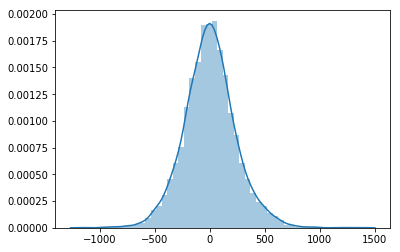

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.ion()

sns.distplot([unvectorized_prior_sampler() for _ in range(5000)]);

Nice! Everything works! Now lets try to do the same but taking advantage of `size` to draw multiple values at once and vectorize operations

In [20]:
unvectorized_prior_sampler(size=5000)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

Oh no! **We can't use the same `size` argument for drawing from every distribution, because it doesn't broadcast well with the implicit distribution's shape**.

What we want to do is set the `sample_shape` instead, which is agnostic of each distribution's shape, so will try to work around the `distribution_shape`.

In [21]:
# This implementation uses the argument sample_shape incorrectly
def incorrect_vectorized_prior_sampler(X=np.arange(3), sample_shape=None):
    normal = np.random.normal
    if sample_shape is None:
        sample_shape = ()
    try:
        sample_shape = tuple(sample_shape)
    except TypeError:
        sample_shape = (sample_shape,)
    beta_g = normal(0, 1, size=sample_shape)
    gamma = np.random.gamma(10, 10, size=sample_shape)
    # We add the distribution's shape at the end of sample_shape
    z = normal(np.zeros(X.shape[-1]), 1, size=sample_shape + (X.shape[-1],))
    beta = beta_g + gamma * z
    sigma = np.random.gamma(3, 3, size=sample_shape)
    return normal(np.dot(X, beta), sigma, size=sample_shape)

In [22]:
incorrect_vectorized_prior_sampler(sample_shape=5000)

ValueError: operands could not be broadcast together with shapes (5000,) (5000,3) 

Still not working! Lets zoom-in to what is causing the error. We see that we are summing `beta_g`'s samples with the product of `gamma` and `z`'s samples. Let's look at the shapes of the samples:

* `beta_g.shape == sample_shape`
* `gamma.shape == sample_shape`
* `z.shape == sample_shape + (X.shape[-1],)`

So in our particular examples these are shaped as:

* `beta_g.shape == (5000,)`
* `gamma.shape == (5000,)`
* `z.shape == (5000, 3)`

So it makes sense that the product of `gamma` with `z` does not broadcast. You could ask yourself, **why did this work at all when we call this function with `sample_shape=None`?** The answer is that a single sample from each distribution (calling with `sample_shape=()`), has the distribution's implicit `shape`, and those **DO BROADCAST CORRECTLY**:

* `beta_g.shape == ()`
* `gamma.shape == ()`
* `z.shape == (3,)`

To make our model's data generation process fully vectorized we need two things:

1. To ensure that all the mathematical operations (sums, products, dots) and all the conditional dependences between variables (like $y$ and $\vec{\beta}$) work on the distribution's core dimensions (`batch_shape + event_shape`). We choose this name to stick with numpy's glossary of generalized universal functions.
2. That the mathematical operations be vectorized on the extra dimensions added by the requested `sample_shape` (something like what is done with [numpy's generic ufuncs](https://docs.scipy.org/doc/numpy/reference/c-api.generalized-ufuncs.html)).

In [23]:
# Overly expressive but _almost_ fully vectorized implementation
def vectorized_prior_sampler(X=np.arange(3), sample_shape=None):
    normal = np.random.normal
    if sample_shape is None:
        sample_shape = ()
    try:
        sample_shape = tuple(sample_shape)
    except TypeError:
        sample_shape = (sample_shape,)
    beta_g = normal(0, 1, size=sample_shape)
    gamma = np.random.gamma(10, 10, size=sample_shape)
    # We add the distribution's shape at the end of sample_shape
    z = normal(np.zeros(X.shape[-1]), 1, size=sample_shape + (X.shape[-1],))
    beta = beta_g[..., None] + gamma[..., None] * z
    sigma = np.random.gamma(3, 3, size=sample_shape)
    return normal(np.einsum("...i,...i", X, beta), sigma, size=sample_shape)

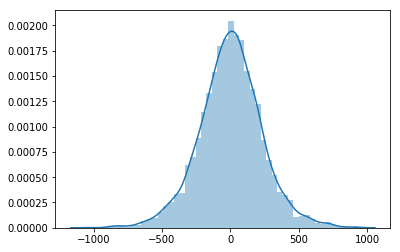

In [24]:
sns.distplot(vectorized_prior_sampler(sample_shape=5000));

Things can still go horribly wrong if we pass a stack of multiple `X` vectors. This is a big deal because it happens when we set more than a single observed `X` and `y`.

In [25]:
X = np.tile(np.arange(3).reshape((1, 3)), (10, 1))
vectorized_prior_sampler(X=X, sample_shape=5000)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (10,3)->(10,3) (5000,3)->(5000,3) 

To solve this, we need to make our `einsum` aware of the extra observation dimensions in `X`, and then ensure that the result broadcasts with samples taken from `sigma`.

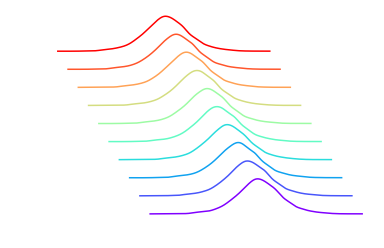

In [26]:
# fully vectorized implementation
def prior_sampler(X=np.arange(3), sample_shape=None):
    normal = np.random.normal
    if sample_shape is None:
        sample_shape = ()
    try:
        sample_shape = tuple(sample_shape)
    except TypeError:
        sample_shape = (sample_shape,)
    beta_g = normal(0, 1, size=sample_shape)
    gamma = np.random.gamma(10, 10, size=sample_shape)
    # We add the distribution's shape at the end of sample_shape
    z = normal(np.zeros(X.shape[-1]), 1, size=sample_shape + (X.shape[-1],))
    beta = beta_g[..., None] + gamma[..., None] * z
    sigma = np.random.gamma(3, 3, size=sample_shape)
    if X.ndim == 1:
        signature = "...i,...i"
    else:
        signature = "...{0}i,...i->...{0}".format("".join([chr(106 + dim) for dim in range(X.ndim - 1)]))
        sigma = np.reshape(sigma, sigma.shape + (1,) * (X.ndim - 1))
    return normal(np.einsum(signature, X, beta), sigma, size=sample_shape + (X.shape[:-1]))

X = np.tile(np.arange(3).reshape((1, 3)), (10, 1))
prior = prior_sampler(X=X, sample_shape=5000)

colors = [plt.get_cmap("rainbow")(x) for x in np.linspace(0, 1, len(X))]
plt_x = np.linspace(
    np.floor(np.min(prior) / 1) * 1,
    np.ceil(np.max(prior) / 1) * 1,
    1000
)
for offset, (p, color) in enumerate(zip(prior.T, colors)):
    plt_y = stats.gaussian_kde(p)(plt_x)
    plt.plot(plt_x - offset * 100, plt_y + offset * 0.001, color=color)
plt.axis("off");

#### Summary

All of this data generation process using raw `numpy` was intended to showcase that:

* When you write down a model and only think about the distribution's core dimensions, this will in general make it difficult to generate data (sample the prior or posterior predictive) in a vectorized fashion.
* To ensure proper vectorization, the mathematical operations that act on RVs **must work on the core dimensions and be vectorized on the extra axes**.
* The RVs that are themselves parameters of other distributions downstream will have an extra `sample_shape` axes when generating data. This means that **the distribution parameters must be broadcastable excluding the `sample_shape` parts**.

pymc3 does most of this for you in `sample_prior_predictive` and `sample_posterior_predictive`. When we write down a model in pymc3, we can easily identify the distribution core dimensions. This allows us to vectorize the mathematical operations using `numpy.vectorize` with an adequate signature. Furthermore, the distribution parameters are broadcasted ignoring the `sample_shape` part thanks to the utilities defined in the [`pymc3.distributions.shape_utils` module](https://docs.pymc.io/api/shape_utils.html). **However, at the moment this broadcasting works for scalar distributions only, the multivariate distributions are still not fully vectorized.**

### PyMC3 shape model construction

Before looking at the equivalent data generation model from above but written in pymc3, I'll briefly remind you of three major things that one should always do with shapes in pymc3 models:

1. When we create random variables inside a model, their `shape` cannot be implicitly inferred from the distribution parameters. This means that if we want to have multidimensional or batches of distributions **we need to specify the desired `shape` during the distribution's instantiation**.
2. When we create a random variable and specify the `shape`, we are not setting the random variable's `shape`, **we are setting the distribution's `shape` and the distribution's core dimensions**.
3. When a random variable is given observations, **the `ObservedRV`'s `shape`** (not the underlying distribution's shape) **is determined by the `observed` argument.** At the moment, there are no checks in place between the `ObservedRV` and the underlying distribution's shapes, but in the near future, an error will be raised if the `ObservedRV`'s shape is not consistent with a sample, with a given `sample_shape`, drawn from the underlying distribution.

Handling observations is really important in pymc3, so I'll stop here a bit because there are a lot of ambiguous things revolving around `shapes`. Essentially `ObservedRV`s have an `observed` attribute that represent the data that they have observed. This data should have a `shape` that looks like `sample_shape + distribution_shape`. The distribution's `shape` should always be provided, or it will be assumed to represent a scalar RV (`distribution_shape=()` and hence zero core dimensions). When we draw samples from the posterior predictive distribution, we let the `ObservedRV`s `shape` be treated as the distribution's `shape`. When we draw samples from the prior predictive distribution, we want to ignore the `ObservedRV`'s `shape` and just work with the underlying distribution's `shape` (this is currently not working due to an [old open issue](https://github.com/pymc-devs/pymc3/issues/1094)).

Now lets define our model in pymc3

/home/lpaz/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


{'sigma': array(0.86392362), 'z': array([ 0.58161754, -0.92677227,  0.60365752]), 'gamma': array(0.90931996), 'sigma_log__': -0.1462709159678767, 'beta_g': array(-1.14124179), 'gamma_log__': -0.09505825242743682}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, z, gamma, beta_g]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:16<00:00, 124.98draws/s]
The number of effective samples is smaller than 25% for some parameters.


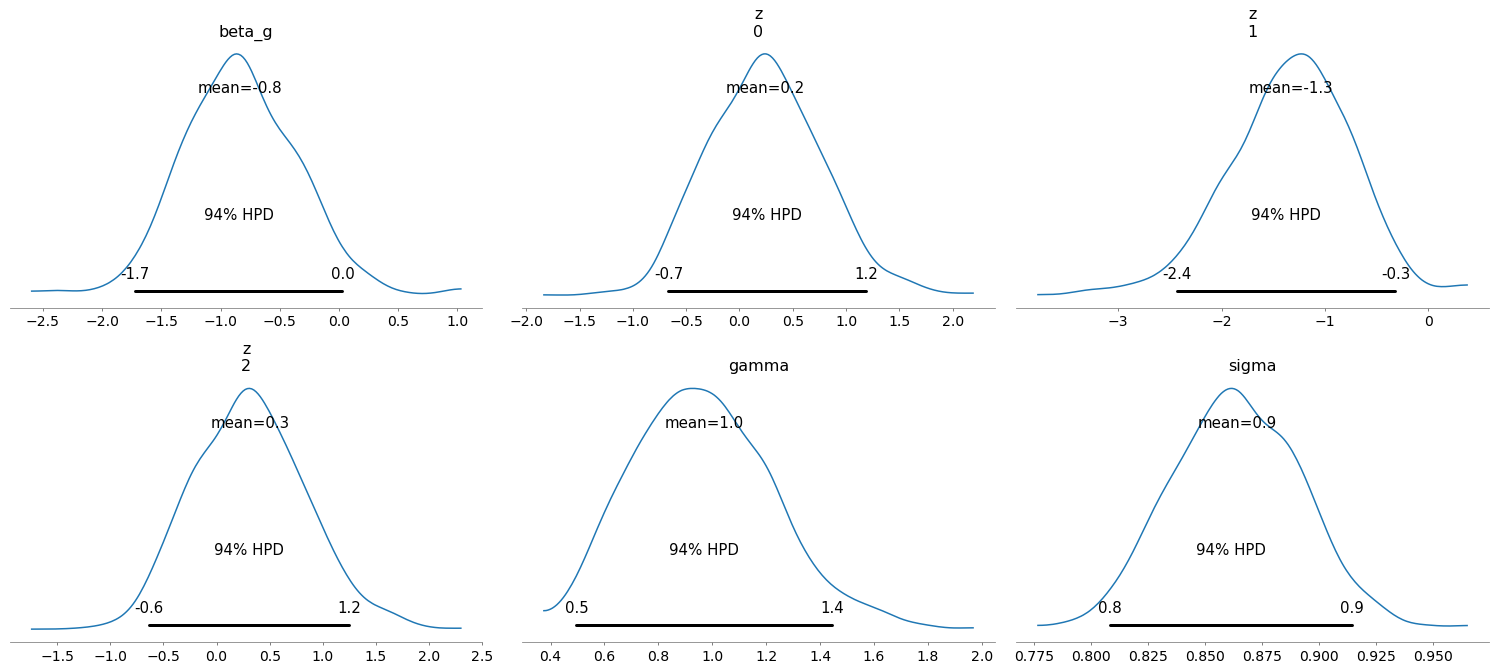

In [27]:
import numpy as np
import theano
from theano import tensor as tt
import pymc3 as pm


# Model definition is encapsulated to easily use with or without observations
def model_factory(X=np.arange(3), y=None):
    with pm.Model() as model:
        beta_g = pm.Normal("beta_g", mu=0, sigma=1)
        gamma = pm.Gamma("gamma", alpha=10, beta=10)
        z = pm.Normal("z", mu=0, sigma=1, shape=X.shape[1])
        sigma = pm.Gamma("sigma", alpha=3, beta=3)
        beta = beta_g + gamma * z
        y = pm.Normal(
            "y",
            mu=tt.dot(X, beta),
            sigma=sigma,
            shape=X.shape[:-1],
            observed=y
        )
    return model

# Data generation
X = np.random.randn(400, 3)
X[:, 0] = 1.
with model_factory(X):
    prior = pm.sample_prior_predictive(samples=1)
y = prior.pop("y")
true_parameters = prior
print(true_parameters)

# Inference
with model_factory(X, y) as model:
    trace = pm.sample()
    pm.plot_posterior(trace)

The resulting trace seems mostly fine, the posterior densities are around where they should be, and the model seems to have converged well enough (I don't show the checks here to avoid clobbering the post). Lets just pay attention to the `shape` parameters that I passed along in the model's definition.

* I wrote a factory function to be able to easily create a model I'll use without observations to use `sample_prior_predictive` to generate a set of observations.
* Then, I create a second model passing the observed data to do inference.
* All the distributions that are not scalar have a specified `shape`, including the observed `y`. This is because, the distribution `shape` cannot be inferred properly from the distribution parameters.

We can view some of the **differences between RV and distribution shapes** with this model:

In [28]:
def rv_shape_info(model, rv):
    try:
        shape = "is a symbolic theano expression that evaluates to {}".format(rv.shape.eval())
    except:
        shape = "is a symbolic theano expression, unknown until runtime"
    return (
        "RV name = {}.\n"
        "Type of RV = {}.\n"
        "RV shape {}.\n"
        "Distribution shape = {}\n"
        "logp shape = {}.\n".
        format(
            rv.name,
            type(rv),
            shape,
            rv.distribution.shape,
            rv.logp_elemwise(model.test_point).shape
        )
    )

In [29]:
beta_g = model.beta_g
print(rv_shape_info(model, beta_g))

RV name = beta_g.
Type of RV = <class 'pymc3.model.FreeRV'>.
RV shape is a symbolic theano expression, unknown until runtime.
Distribution shape = []
logp shape = ().



In [30]:
z = model.z
print(rv_shape_info(model, z))

RV name = z.
Type of RV = <class 'pymc3.model.FreeRV'>.
RV shape is a symbolic theano expression, unknown until runtime.
Distribution shape = [3]
logp shape = (3,).



In [31]:
y = model.y
print(rv_shape_info(model, y))

RV name = y.
Type of RV = <class 'pymc3.model.ObservedRV'>.
RV shape is a symbolic theano expression that evaluates to [400].
Distribution shape = [400]
logp shape = (400,).



### Shape handling in `logp`

You may have noticed that I printed something I called `logp shape`. Lets look at what that is. Each `Distribution` has a `logp` method with the following signature:


```python
...
def logp(self, value):
    ...
```

It takes an input `value` and returns a `theano` expression that can later be compiled to compute the logarithm of the probability density function of the distribution, conditioned on the `value` input. When an RV is instantiated, the distribution's `logp` is called with one of two possible inputs:

1. If no `observed` is provided, `logp` is called passing the RV as the `value` argument
2. If `observed` is provided, `logp` is called passing `observed` as the `value` argument

Keep in mind that this simply returns a `theano.tensor`, called `logp_elemwiset`, so it still has no value, and hence no shape to check. pymc3 later provides the RVs with two convenience methods to compute `logp` numerical values by compiling the returned `theano.tensor` into a function. The first is the widely known `rv.logp` method, which computes the sum of the `logp_elemwiset` on a given point input. The second, less known method, is `rv.logp_elemwise`, which simply returns the numerical output of `logp_elemwiset` on a given point input. **This means that we can use `rv.logp_elemwise` to check how a given distribution handles the logp's output `shape`**

If you recall the discussion on `event_shape` and `batch_shape`, we can compare the `logp`s of a batch of normals versus a multivariate normal on a given set of observations

In [32]:
def model_factory(batch_shape, event_shape, batch_obs=None, event_obs=None):
    with pm.Model() as model:
        batch = pm.Normal(
            "batch",
            mu=0,
            sigma=1,
            shape=batch_shape,
            observed=batch_obs,
        )
        event = pm.MvNormal(
            "event",
            mu=np.zeros(event_shape),
            cov=np.diag(np.ones(event_shape)),
            shape=event_shape,
            observed=event_obs,
        )
    return model

batch_shape = (3,)
event_shape = (3,)
sample_shape = (4,)
# We generate data to later be used as observations
test_model = model_factory(batch_shape, event_shape)
b = test_model.batch.random(size=sample_shape)
e = test_model.event.random(size=sample_shape)

# We create the model passing observations to the RVs so that we can compute logp
test_model = model_factory(batch_shape, event_shape, batch_obs=b, event_obs=b)
point = {"batch": b, "event": e}
blp = test_model.batch.logp_elemwise(point)
elp = test_model.event.logp_elemwise(point)

print("Shape of draw from a batch of normals        = {}".format(b.shape))
print("Shape of draw from an MvNormal               = {}".format(e.shape))
print("Shape of logp output from a batch of normals = {}".format(blp.shape))
print("Shape of logp output from an MvNormal        = {}".format(elp.shape))
print("Total logp output from a batch of normals    = {}".format(np.sum(blp)))
print("Total logp output from an MvNormal           = {}".format(np.sum(elp)))

Shape of draw from a batch of normals        = (4, 3)
Shape of draw from an MvNormal               = (4, 3)
Shape of logp output from a batch of normals = (4, 3)
Shape of logp output from an MvNormal        = (4,)
Total logp output from a batch of normals    = -22.535408832791916
Total logp output from an MvNormal           = -22.53540883279192


The previous example highlights the following:

* `event_shape` and `batch_shape` are implicit to a distribution, and only accessible through a single `shape` argument.
* The `logp` computations distinguish between the `event_shape` and `batch_shape` of distributions, but drawing samples from distributions does not.

### Posterior predictive sampling

We can now draw samples from the posterior predictive distribution and check the output's shape. What we do at the moment is:

* We iterate through the points in the `trace` one at a time. This means that the RV values provided will only have their core dimensions. This makes forward sampling safer but slower.
* We use the `ObservedRV`'s `shape` as the `distribution_shape`, so all samples should have `shape=(number_of_points_in_trace,) + observedRV.shape.eval()`.

In [33]:
print("Total number of points in trace = {}".format(len([p for p in trace.points()])))

Total number of points in trace = 1000


In [34]:
with model:
    ppc = pm.sample_posterior_predictive(trace)
ppc["y"].shape

100%|██████████| 1000/1000 [00:01<00:00, 829.93it/s]


(1000, 400)

To better highlight the `shape` difference in sampling from an `ObservedRV`s prior distribution and its posterior predictive we'll use the following model:

In [35]:
with pm.Model() as model:
    mu = pm.Normal("mu", 0, 1)
    obs = pm.Normal("obs", mu, 1, shape=(3,), observed=np.random.randn(10, 3) + 1)
    prior = obs.distribution.random(size=100)
    trace = pm.sample()
    ppc = pm.sample_posterior_predictive(trace, samples=100)
print("Shape of samples drawn from the prior distribution = {}".format(prior.shape))
print("Shape of samples drawn from the posterior predictive = {}".format(ppc["obs"].shape))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 2665.14draws/s]
/home/lpaz/repos/pymc3/pymc3/sampling.py:1109: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn("samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:00<00:00, 2240.26it/s]

Shape of samples drawn from the prior distribution = (100, 3)
Shape of samples drawn from the posterior predictive = (100, 10, 3)
